**Colab link:** https://drive.google.com/file/d/1aDgEJGg3FWT0I9KwllnO3nFln_t-Pbmc/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install git+https://github.com/huggingface/transformers.git
! pip install git+https://github.com/huggingface/datasets.git
! pip install sacrebleu sentencepiece
! pip install rouge-score nltk
! pip install tensorflow_text
! pip install googletrans==4.0.0rc1

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-9j_x4ujj
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-9j_x4ujj
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 9.1 MB/s 
     |████████████████████████████████| 596 kB 59.6 MB/s 
     |████████████████████████████████| 61 kB 568 kB/s 
     |████████████████████████████████| 3.3 MB 69.6 MB/s 
  Created wheel for transformers: filename=transformers-4.14.0.dev0-py3-none-any.whl size=3320842 sha256=68a97f26eb297f5ef4fcdfb51f66a1e451a7c8575233f5ee0206a8dc5e89d7ba
  Stored in directory: /tmp/pip-ephem-wheel-cache-_n3vjow7/wheels/90/a5/44/6bcd83827c8a60628c5ad602f429cd5076bcce5f2a90054947
Successfully built transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [3]:
import transformers
import datasets
from transformers import (AutoTokenizer,
                          TFAutoModelForSeq2SeqLM, 
                          DataCollatorForSeq2Seq,
                          AdamWeightDecay,
                          AutoModelForSeq2SeqLM)
from datasets import load_dataset, load_metric

import random
import numpy as np
import pandas as pd
import collections

import tensorflow as tf
import tensorflow_text as tf_text

import typing
from typing import Any, Tuple

from sklearn.metrics import (hamming_loss, 
                             f1_score, 
                             precision_score, 
                             recall_score,
                             multilabel_confusion_matrix)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import googletrans
from googletrans import Translator

In [4]:
ROOT_FOLDER_MODEL = '/content/drive/MyDrive/685 Project'

#### Data

In [5]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option('display.max_colwidth', None)

In [6]:
def get_data_with_window(df_raw, window, seed=685, include_summary=False):

  if window == 0:

    df_processed = pd.DataFrame()

    for index, row in df_raw.iterrows():
      label = 'N: ' + (' '.join(sorted(str(row['News Sentiment and Emotion']).split()))).lower() + ' C: '+ (' '.join(sorted(str(row['Public Sentiment and Emotion']).split())).lower() )
      text = 'Media: ' + str(row['Media']) + ' E: ' + str(row['Event'])
      df_processed = df_processed.append({'text': text, 'label': label, 'entity': row['Entity'], 'media': row['Media'], 'event': row['Event']}, ignore_index=True)
      
    df_processed = df_processed.sample(frac=1, random_state=seed)
    
    return df_processed
  
  elif window == 2:

    df_raw = df_raw.sort_values(by=['Media', 'Entity', 'Sequence Number'])

    df_processed = pd.DataFrame()

    last_row = None 
    second_last_row = None
    last_entity_media = None
    count = 0

    for index, row in df_raw.iterrows():

      if last_entity_media:
        if last_entity_media == row['Media'] + ' ' + row['Entity']:
          count = count + 1
          if count > 2:
            if include_summary:
              text = 'Media: ' + str(row['Media']) + ' N1: ' + str(last_row['Headline']) + ' ' + (str(last_row['Article Body Summary']) if last_row['Article Body Summary'] != 'NAN' else '') + ' C1: ' + str(last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + ' N2: ' + str(second_last_row['Headline']) + ' ' + str(last_row['Article Body Summary']) + ' C2: ' + str(second_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + ' E: ' + str(row['Event'])
            else:
              text = 'Media: ' + str(row['Media']) + ' N1: ' + str(last_row['Headline']) + ' C1: ' + str(last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + ' N2: ' + str(second_last_row['Headline']) + ' C2: ' + str(second_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + ' E: ' + str(row['Event'])
            label = 'N: ' + (' '.join(sorted(str(row['News Sentiment and Emotion']).split()))).lower() + ' C: ' + (' '.join(sorted(str(row['Public Sentiment and Emotion']).split()))).lower()
            df_processed = df_processed.append({'text': text, 'label': label, 'entity': row['Entity'], 'media': row['Media']}, ignore_index=True)
            second_last_row = last_row
            last_row = row
          elif count == 1:
            second_last_row = row 
          elif count == 2:
            last_row = row 
        else:
          count = 1
          second_last_row = row 
          last_entity_media = row['Media'] + ' ' + row['Entity']
      else:
        count = 1
        second_last_row = row 
        last_entity_media = row['Media'] + ' ' + row['Entity']

    df_processed = df_processed.sample(frac=1, random_state=seed)

    return df_processed
  
  elif window == 3:

    df_raw = df_raw.sort_values(by=['Media', 'Entity', 'Sequence Number'])

    df_processed = pd.DataFrame()

    last_row = None 
    third_last_row = None
    second_last_row = None
    last_entity_media = None
    count = 0

    for index, row in df_raw.iterrows():

      if last_entity_media:
        if last_entity_media == row['Media'] + ' ' + row['Entity']:
          count = count + 1
          if count > 3:
            if include_summary:
              text = 'Media: ' + str(row['Media']) + ' N1: ' + str(last_row['Headline']) + ' ' + (str(last_row['Article Body Summary']) if last_row['Article Body Summary'] != 'NAN' else '') + ' C1: ' + str(last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N2: ' + str(second_last_row['Headline']) + ' ' + (str(second_last_row['Article Body Summary']) if second_last_row['Article Body Summary'] != 'NAN' else '') + ' C2: ' + str(second_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N3: ' + str(third_last_row['Headline']) + ' ' + (str(third_last_row['Article Body Summary']) if third_last_row['Article Body Summary'] != 'NAN' else '') + ' C3: ' + str(third_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' E: ' + str(row['Event'])
            else:
              text = 'Media: ' + str(row['Media']) + ' N1: ' + str(last_row['Headline']) + ' C1: ' + str(last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N2: ' + str(second_last_row['Headline']) + ' C2: ' + str(second_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N3: ' + str(third_last_row['Headline']) + ' C3: ' + str(third_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' E: ' + str(row['Event'])
            label = 'N: ' + (' '.join(sorted(str(row['News Sentiment and Emotion']).split()))).lower() + ' C: ' + (' '.join(sorted(str(row['Public Sentiment and Emotion']).split()))).lower()
            df_processed = df_processed.append({'text': text, 'label': label, 'entity': row['Entity'], 'media': row['Media']}, ignore_index=True)
            third_last_row = second_last_row
            second_last_row = last_row
            last_row = row
          elif count == 1:
            third_last_row = row
          elif count == 2:
            second_last_row = row 
          elif count == 3:
            last_row = row 
        else:
          count = 1
          third_last_row = row 
          last_entity_media = row['Media'] + ' ' + row['Entity']
      else:
        count = 1
        third_last_row = row 
        last_entity_media = row['Media'] + ' ' + row['Entity']

    df_processed = df_processed.sample(frac=1, random_state=seed)

    return df_processed

  elif window == 4:

    df_raw = df_raw.sort_values(by=['Media', 'Entity', 'Sequence Number'])

    df_processed = pd.DataFrame()

    last_row = None 
    third_last_row = None
    second_last_row = None
    fourth_last_row = None
    last_entity_media = None
    count = 0

    for index, row in df_raw.iterrows():

      if last_entity_media:
        if last_entity_media == row['Media'] + ' ' + row['Entity']:
          count = count + 1
          if count > 4:
            if include_summary:
              text = 'Media: ' + str(row['Media']) + ' N1: ' + str(last_row['Headline']) + ' ' + (str(last_row['Article Body Summary']) if last_row['Article Body Summary'] != 'NAN' else '') + ' C1: ' + str(last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N2: ' + str(second_last_row['Headline']) + ' ' + (str(second_last_row['Article Body Summary']) if second_last_row['Article Body Summary'] != 'NAN' else '') + ' C2: ' + str(second_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N3: ' + str(third_last_row['Headline']) + ' ' + (str(third_last_row['Article Body Summary']) if third_last_row['Article Body Summary'] != 'NAN' else '') + ' C3: ' + str(third_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N4: ' + str(fourth_last_row['Headline']) + ' ' + (str(fourth_last_row['Article Body Summary']) if fourth_last_row['Article Body Summary'] != 'NAN' else '') + ' C4: ' + str(fourth_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' E: ' + str(row['Event'])
            else:
              text = 'Media: ' + str(row['Media']) + ' N1: ' + str(last_row['Headline']) + ' C1: ' + str(last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N2: ' + str(second_last_row['Headline']) + ' C2: ' + str(second_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N3: ' + str(third_last_row['Headline']) + ' C3: ' + str(third_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N4: ' + str(fourth_last_row['Headline']) + ' C4: ' + str(fourth_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' E: ' + str(row['Event'])
            label = 'N: ' + (' '.join(sorted(str(row['News Sentiment and Emotion']).split()))).lower() + ' C: ' + (' '.join(sorted(str(row['Public Sentiment and Emotion']).split()))).lower()
            df_processed = df_processed.append({'text': text, 'label': label, 'entity': row['Entity'], 'media': row['Media']}, ignore_index=True)
            fourth_last_row = third_last_row
            third_last_row = second_last_row
            second_last_row = last_row
            last_row = row
          elif count == 1:
            fourth_last_row = row
          elif count == 2:
            third_last_row = row 
          elif count == 3:
            second_last_row = row 
          elif count == 4:
            last_row = row 
        else:
          count = 1
          fourth_last_row = row 
          last_entity_media = row['Media'] + ' ' + row['Entity']
      else:
        count = 1
        fourth_last_row = row 
        last_entity_media = row['Media'] + ' ' + row['Entity']

    df_processed = df_processed.sample(frac=1, random_state=seed)

    return df_processed

  elif window == 5:

    df_raw = df_raw.sort_values(by=['Media', 'Entity', 'Sequence Number'])

    df_processed = pd.DataFrame()

    last_row = None 
    third_last_row = None
    second_last_row = None
    fourth_last_row = None
    fifth_lat_row = None
    last_entity_media = None
    count = 0

    for index, row in df_raw.iterrows():

      if last_entity_media:
        if last_entity_media == row['Media'] + ' ' + row['Entity']:
          count = count + 1
          if count > 5:
            if include_summary:
              text = 'Media: ' + str(row['Media']) + ' N1: ' + str(last_row['Headline']) + ' ' + (str(last_row['Article Body Summary']) if last_row['Article Body Summary'] != 'NAN' else '') + ' C1: ' + str(last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N2: ' + str(second_last_row['Headline']) + ' ' + (str(second_last_row['Article Body Summary']) if second_last_row['Article Body Summary'] != 'NAN' else '') + ' C2: ' + str(second_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N3: ' + str(third_last_row['Headline']) + ' ' + (str(third_last_row['Article Body Summary']) if third_last_row['Article Body Summary'] != 'NAN' else '') + ' C3: ' + str(third_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N4: ' + str(fourth_last_row['Headline']) + ' ' + (str(fourth_last_row['Article Body Summary']) if fourth_last_row['Article Body Summary'] != 'NAN' else '') + ' C3: ' + str(fourth_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N5: ' + str(fifth_last_row['Headline']) + ' ' + (str(fifth_last_row['Article Body Summary']) if fifth_last_row['Article Body Summary'] != 'NAN' else '') + ' C3: ' + str(fifth_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' E: ' + str(row['Event'])
            else:
              text = 'Media: ' + str(row['Media']) + ' N1: ' + str(last_row['Headline']) + ' C1: ' + str(last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N2: ' + str(second_last_row['Headline']) + ' C2: ' + str(second_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N3: ' + str(third_last_row['Headline']) + ' C3: ' + str(third_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N4: ' + str(fourth_last_row['Headline']) + ' C3: ' + str(fourth_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' N5: ' + str(fifth_last_row['Headline']) + ' C3: ' + str(fifth_last_row['Comment 1']).replace('C1:', '').replace('C2:', '') + \
            ' E: ' + str(row['Event'])
            label = 'N: ' + (' '.join(sorted(str(row['News Sentiment and Emotion']).split()))).lower() + ' C: ' + (' '.join(sorted(str(row['Public Sentiment and Emotion']).split()))).lower()
            df_processed = df_processed.append({'text': text, 'label': label, 'entity': row['Entity'], 'media': row['Media']}, ignore_index=True)
            fifth_last_row = fourth_last_row
            fourth_last_row = third_last_row
            third_last_row = second_last_row
            second_last_row = last_row
            last_row = row
          elif count == 1:
            fifth_last_row = row
          elif count == 2:
            fourth_last_row = row 
          elif count == 3:
            third_last_row = row 
          elif count == 4:
            second_last_row = row 
          elif count == 5:
            last_row = row
        else:
          count = 1
          fifth_last_row = row 
          last_entity_media = row['Media'] + ' ' + row['Entity']
      else:
        count = 1
        fifth_last_row = row 
        last_entity_media = row['Media'] + ' ' + row['Entity']

    df_processed = df_processed.sample(frac=1, random_state=seed)

    return df_processed


def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    
    df = df.sample(frac=1, random_state=seed)

    df['assignment'] = ''
    random.seed(seed)
    
    for index, row in df.iterrows():
      p = random.uniform(0, 1)
      
      if row['assignment'] == '':
        assignment = 'train' if p <= train_percent else ('val' if (p > train_percent and p <= (train_percent + validate_percent)) else 'test' )
        df.loc[(df['Entity'] == row['Entity']), 'assignment'] = assignment

    return (df.loc[df['assignment'] == 'train'],
           df.loc[df['assignment'] == 'val'],
           df.loc[df['assignment'] == 'test'])

In [9]:
df_raw = pd.read_csv('/content/nlp_data.csv')

train_df, val_df, test_df = train_validate_test_split(df_raw, .6, .2, seed=685)

print(f"Training Size: {len(train_df)}")
print(f"Validation Size: {len(val_df)}")
print(f"Test Size: {len(test_df)}")

Training Size: 428
Validation Size: 121
Test Size: 143


In [10]:
plot_df = [get_data_with_window(train_df, 0),
           get_data_with_window(val_df, 0),
           get_data_with_window(test_df, 0)]

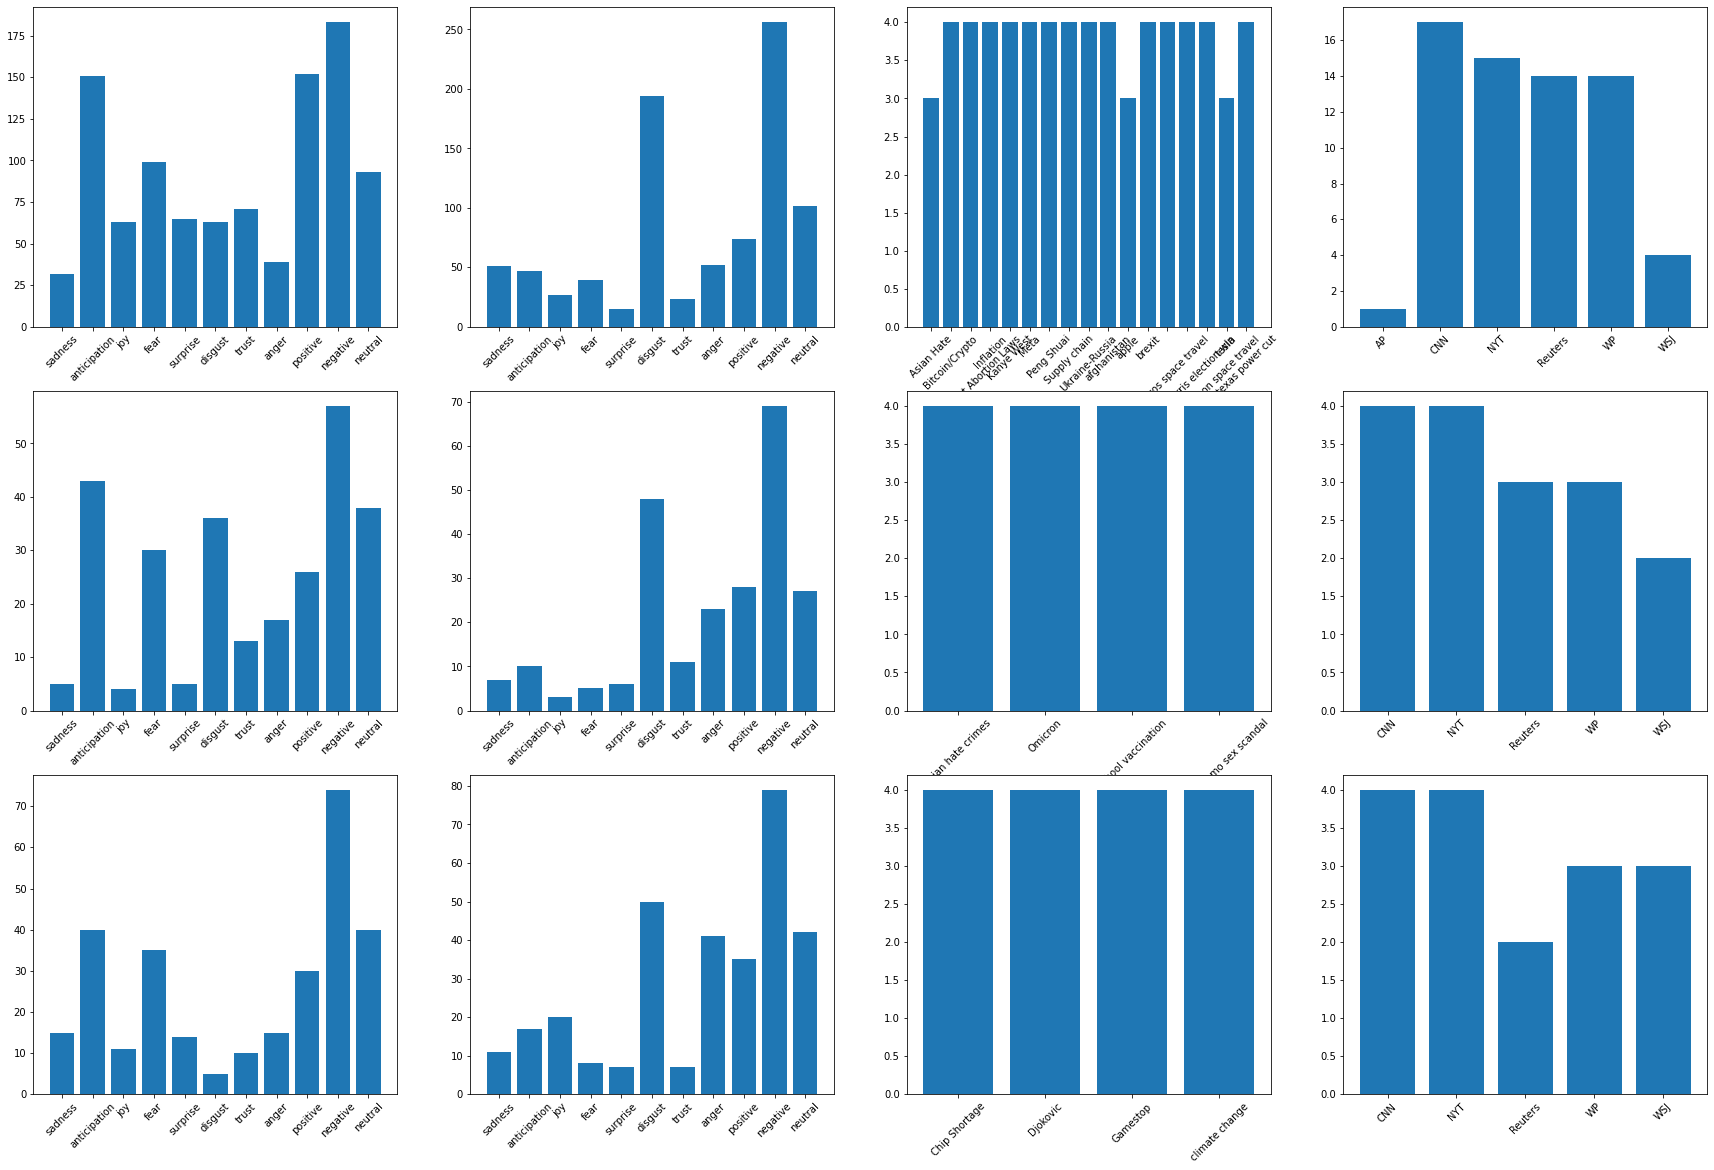

In [11]:
plt.figure(figsize=(30, 20))

for p in range(3):

  cnt_emotions_news = collections.Counter()
  cnt_emotions_news.update({'sadness': 0, 'anticipation': 0, 'joy': 0, 'fear': 0, 'surprise': 0, 'disgust': 0, 'trust': 0, 'anger': 0,
                            'positive': 0, 'negative': 0, 'neutral': 0})
  for i, l in enumerate(plot_df[p]['label'].tolist()):
    l = l.split(':')[1]
    cnt_emotions_news.update(l.split())
  del cnt_emotions_news['C']

  cnt_emotions_comments = collections.Counter()
  cnt_emotions_comments.update({'sadness': 0, 'anticipation': 0, 'joy': 0, 'fear': 0, 'surprise': 0, 'disgust': 0, 'trust': 0, 'anger': 0,
                            'positive': 0, 'negative': 0, 'neutral': 0})
  for i, l in enumerate(plot_df[p]['label'].tolist()):
    l = l.split(':')[2]
    cnt_emotions_comments.update(l.split())
  del cnt_emotions_comments['C']

  entity = plot_df[p].groupby('entity')['media'].nunique()
  media = plot_df[p].groupby('media')['entity'].nunique()

  plt.subplot(3, 4, p * 4 + 1)
  plt.bar(cnt_emotions_news.keys(), cnt_emotions_news.values())
  plt.xticks(rotation = 45)

  plt.subplot(3, 4, p * 4 + 2)
  plt.bar(cnt_emotions_comments.keys(), cnt_emotions_comments.values())
  plt.xticks(rotation = 45)

  plt.subplot(3, 4, p * 4 + 3)
  plt.bar(entity.index, entity.values)
  plt.xticks(rotation = 45)

  plt.subplot(3, 4, p * 4 + 4)
  plt.bar(media.index, media.values)
  plt.xticks(rotation = 45)


#### Evaluation

In [12]:
def evaluate(target, pred, sep1 = ":", sep2 = ":", pos1 = (0,1), pos2 = (0,1)):
  
  from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score

  def get_matrix(label, labels_number):
    mat = np.zeros((len(label), labels_number))
    for i, l in enumerate(label):
      l = l.lower()
      mat[i] = [1 if 'sadness' in l else 0, 
                1 if 'anticipation' in l else 0,
                1 if 'joy' in l else 0,
                1 if 'fear' in l else 0,
                1 if 'surprise' in l else 0,
                1 if 'disgust' in l else 0,
                1 if 'trust' in l else 0,
                1 if 'anger' in l else 0,
                1 if 'positive' in l else 0,
                1 if 'negative' in l else 0,
                1 if 'neutral' in l else 0]
    return mat

  decoded_predictions = []
  decoded_labels = target

  decoded_predictions = pred

  decoded_labels_1 = []
  decoded_labels_2 = []
  for d in decoded_labels:
    decoded_labels_1.append(d.split(sep1)[pos1[0]])
    decoded_labels_2.append(d.split(sep1)[pos1[1]])
  mat1_true = get_matrix(decoded_labels_1, 11)
  mat2_true = get_matrix(decoded_labels_2, 11)

  # print(decoded_labels_1)
  # print(decoded_labels_2)

  decoded_predictions_1 = []
  decoded_predictions_2 = []
  for d in decoded_predictions:
    decoded_predictions_1.append(d.split(sep2)[pos2[0]])
    if len(d.split(sep2)) > pos2[1]:
      decoded_predictions_2.append(d.split(sep2)[pos2[1]])
    else:
      decoded_predictions_2.append('')
  mat1_pred = get_matrix(decoded_predictions_1, 11)
  mat2_pred = get_matrix(decoded_predictions_2, 11)

  # print(decoded_predictions_1)
  # print(decoded_predictions_2)

  result = {}

  result['News Hamming Loss'] = hamming_loss(mat1_true, mat1_pred)
  result['Comment Hamming Loss'] = hamming_loss(mat2_true, mat2_pred)
  result['News Accuracy (Per Class)'] = np.array2string(np.sum(mat1_pred == mat1_true, axis=0) / len(mat1_pred), precision=4, separator=',', suppress_small=True)
  result['Comment Accuracy (Per Class)'] = np.array2string(np.sum(mat2_pred == mat2_true, axis=0) / len(mat2_pred), precision=4, separator=',', suppress_small=True)

  result['News F1 Score (Micro)'] = f1_score(mat1_true, mat1_pred, average='micro', zero_division=1)
  result['News F1 Score (Macro)'] = f1_score(mat1_true, mat1_pred, average='macro', zero_division=1)
  result['News F1 Score (Per Class)'] = np.array2string(f1_score(mat1_true, mat1_pred, average=None, zero_division=1),precision=4, separator=',', suppress_small=True)
  result['Comment F1 Score (Micro)'] = f1_score(mat2_true, mat2_pred, average='micro', zero_division=1)
  result['Comment F1 Score (Macro)'] = f1_score(mat2_true, mat2_pred, average='macro', zero_division=1)
  result['Comment F1 Score (Per Class)'] = np.array2string(f1_score(mat2_true, mat2_pred, average=None, zero_division=1), precision=4, separator=',', suppress_small=True)

  result["News Precision Score (Micro)"] = precision_score(mat1_true, mat1_pred, average='micro', zero_division=1)
  result["News Precision Score (Macro)"] = precision_score(mat1_true, mat1_pred, average='macro', zero_division=1)
  result["News Precision Score (Per Class)"] = np.array2string(precision_score(mat1_true, mat1_pred, average=None, zero_division=1), precision=4, separator=',', suppress_small=True)
  result["Comment Precision Score (Micro)"] = precision_score(mat2_true, mat2_pred, average='micro', zero_division=1)
  result["Comment Precision Score (Macro)"] = precision_score(mat2_true, mat2_pred, average='macro', zero_division=1)
  result["Comment Precision Score (Per Class)"] = np.array2string(precision_score(mat2_true, mat2_pred, average=None, zero_division=1), precision=4, separator=',', suppress_small=True)

  result["News Recall Score (Micro)"] = recall_score(mat1_true, mat1_pred, average='micro', zero_division=1)
  result["News Recall Score (Macro)"] = recall_score(mat1_true, mat1_pred, average='macro', zero_division=1)
  result["News Recall Score (Per Class)"] = np.array2string(recall_score(mat1_true, mat1_pred, average=None, zero_division=1), precision=4, separator=',', suppress_small=True)
  result["Comment Recall Score (Micro)"] = recall_score(mat2_true, mat2_pred, average='micro', zero_division=1)
  result["Comment Recall Score (Macro)"] = recall_score(mat2_true, mat2_pred, average='macro', zero_division=1)
  result["Comment Recall Score (Per Class)"] = np.array2string(recall_score(mat2_true, mat2_pred, average=None, zero_division=1), precision=4, separator=',', suppress_small=True)

  return result
                                                                                                                                       

#### Baseline 1

In [13]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")


def tf_lower_and_split_punct(text):
  
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  
  return text


class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state


class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights


class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)


class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any


class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any


def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state


class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)


class TrainSeqToSeq(tf.keras.Model):
  
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    
    super().__init__()
    
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)


def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask


def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}


def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state


@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)


class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')


class SeqGenerator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))


def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text


def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens


def seq_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=0.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_generate(self, input_text):
  return self.generate(input_text)

In [14]:
def train_seq_to_seq_baseline(train_df, val_df, test_df):

  targ, inp = train_df['label'].tolist(), train_df['text'].tolist()
  targ_val, inp_val = val_df['label'].tolist(), val_df['text'].tolist()
  targ_test, inp_test = test_df['label'].tolist(), test_df['text'].tolist()

  BUFFER_SIZE = len(inp)
  BATCH_SIZE = 8

  dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
  dataset = dataset.batch(BATCH_SIZE)

  val_dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
  val_dataset = dataset.batch(BATCH_SIZE)

  test_dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
  test_dataset = dataset.batch(BATCH_SIZE)

  max_vocab_size = 5000

  input_text_processor = tf.keras.layers.TextVectorization(
      standardize=tf_lower_and_split_punct,
      max_tokens=max_vocab_size)

  input_text_processor.adapt(inp)

  output_text_processor = tf.keras.layers.TextVectorization(
      standardize=tf_lower_and_split_punct,
      max_tokens=max_vocab_size)

  output_text_processor.adapt(targ)

  embedding_dim = 256
  units = 1024

  Decoder.call = call

  TrainSeqToSeq._preprocess = _preprocess
  TrainSeqToSeq._train_step = _train_step
  TrainSeqToSeq._loop_step = _loop_step

  opinionModel = TrainSeqToSeq(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

  # Configure the loss and optimizer
  opinionModel.compile(
      optimizer=tf.optimizers.Adam(),
      loss=MaskedLoss()
  )

  TrainSeqToSeq._tf_train_step = _tf_train_step
  
  opinionModel.use_tf_function = True

  opinionModel.fit(dataset, epochs=20, callbacks=[batch_loss])
  
  generator = SeqGenerator (
    encoder=opinionModel.encoder,
    decoder=opinionModel.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
  )

  SeqGenerator.tokens_to_text = tokens_to_text

  SeqGenerator.sample = sample

  SeqGenerator.generate = seq_unrolled
  SeqGenerator.tf_generate = tf_generate

  return opinionModel, generator

In [13]:
train_df_baseline1 = get_data_with_window(train_df, 0)
val_df_baseline1 = get_data_with_window(val_df, 0)
test_df_baseline1 = get_data_with_window(test_df, 0)

model, generator = train_seq_to_seq_baseline(train_df_baseline1, val_df_baseline1, test_df_baseline1)

Epoch 1/20
54/54 [==============================] - 16s 143ms/step - batch_loss: 1.2028
Epoch 2/20
54/54 [==============================] - 8s 144ms/step - batch_loss: 0.7834
Epoch 3/20
54/54 [==============================] - 8s 146ms/step - batch_loss: 0.7020
Epoch 4/20
54/54 [==============================] - 8s 144ms/step - batch_loss: 0.6449
Epoch 5/20
54/54 [==============================] - 8s 143ms/step - batch_loss: 0.6037
Epoch 6/20
54/54 [==============================] - 8s 148ms/step - batch_loss: 0.5794
Epoch 7/20
54/54 [==============================] - 8s 143ms/step - batch_loss: 0.5543
Epoch 8/20
54/54 [==============================] - 7s 138ms/step - batch_loss: 0.5185
Epoch 9/20
54/54 [==============================] - 7s 136ms/step - batch_loss: 0.5018
Epoch 10/20
54/54 [==============================] - 8s 141ms/step - batch_loss: 0.4888
Epoch 11/20
54/54 [==============================] - 7s 138ms/step - batch_loss: 0.4777
Epoch 12/20
54/54 [=====================

In [14]:
targ, inp = train_df_baseline1['label'].tolist(), train_df_baseline1['text'].tolist()
targ_val, inp_val = val_df_baseline1['label'].tolist(), val_df_baseline1['text'].tolist()
targ_test, inp_test = test_df_baseline1['label'].tolist(), test_df_baseline1['text'].tolist()

# Train
result = generator.tf_generate(input_text = inp)
preds = []
for i in range(len(inp)):
  preds.append(result['text'][i].numpy().decode())
print("Train Evaluation:")
print(evaluate(targ, preds, sep1 = 'C:', sep2 = ' c ', pos1 = (0, 1), pos2 = (0, 1)))
print()

# Val 
result = generator.tf_generate(input_text = inp_val)
preds = []
for i in range(len(inp_val)):
  preds.append(result['text'][i].numpy().decode())
print("Val Evaluation:")
print(evaluate(targ_val, preds, sep1 = 'C:', sep2 = ' c ', pos1 = (0, 1), pos2 = (0, 1)))
print()

# Test
result = generator.tf_generate(input_text = inp_test)
preds = []
for i in range(len(inp_test)):
  preds.append(result['text'][i].numpy().decode())
print("Test Evaluation")
print(evaluate(targ_test, preds, sep1 = 'C:', sep2 = ' c ', pos1 = (0, 1), pos2 = (0, 1)))


Train Evaluation:
{'News Hamming Loss': 0.08050127442650808, 'Comment Hamming Loss': 0.07986406117247238, 'News Accuracy (Per Class)': '[0.972 ,0.8645,0.9673,0.8949,0.9159,0.9556,0.9229,0.9486,0.9136,0.8832,\n 0.8762]', 'Comment Accuracy (Per Class)': '[0.9579,0.9182,0.9603,0.9369,0.972 ,0.8621,0.9439,0.9393,0.9112,0.8411,\n 0.8785]', 'News F1 Score (Micro)': 0.8150317227916056, 'News F1 Score (Macro)': 0.8043901340906019, 'News F1 Score (Per Class)': '[0.7778,0.8153,0.8889,0.7739,0.76  ,0.855 ,0.7402,0.766 ,0.8655,0.867 ,\n 0.7389]', 'Comment F1 Score (Micro)': 0.7846506300114549, 'Comment F1 Score (Macro)': 0.6920251517096667, 'Comment F1 Score (Per Class)': '[0.8085,0.6392,0.5641,0.5263,0.5385,0.8578,0.6   ,0.7347,0.7324,0.8682,\n 0.7426]', 'News Precision Score (Micro)': 0.8044315992292871, 'News Precision Score (Macro)': 0.8073196977319206, 'News Precision Score (Per Class)': '[0.9545,0.7853,0.8889,0.77  ,0.6706,0.8235,0.8393,0.6545,0.9675,0.8446,\n 0.6818]', 'Comment Precision Sc

In [15]:
# Error Analysis
result = generator.tf_generate(input_text = inp_test)
preds = []
for i in range(len(inp_test)):
  print(f"Input: {inp_test[i]}")
  print(f"True: {targ_test[i]}")
  print(f"Prediction: {result['text'][i].numpy().decode()}")
  print()

Input: Media: WSJ E: Gamestop stocks remain high.
True: N: joy positive C: anger joy negative positive trust
Prediction: n anticipation neutral c disgust negative

Input: Media: NYT E: Robinhood said to have caused Wall-Street chaos related to GameStop.
True: N: neutral trust C: anger negative neutral trust
Prediction: n anticipation neutral c anger disgust negative

Input: Media: WSJ E: Everything about GameStop stocks
True: N: neutral C: anticipation neutral
Prediction: n anticipation neutral c disgust negative

Input: Media: WP E: Djokovic looses US open
True: N: negative surprise C: negative surprise
Prediction: n anticipation neutral c disgust negative

Input: Media: WP E: Ocean circulation is showing sign of instability
True: N: anger fear negative C: anger negative
Prediction: n anticipation neutral c anger disgust negative

Input: Media: CNN E: Hurricane Ida occured
True: N: anger fear negative C: anger neutral
Prediction: n anticipation neutral c disgust negative

Input: Media

#### Baseline 2

In [16]:
train_df_baseline2 = get_data_with_window(train_df, 2)
val_df_baseline2 = get_data_with_window(val_df, 2)
test_df_baseline2 = get_data_with_window(test_df, 2)

model, generator = train_seq_to_seq_baseline(train_df_baseline2, val_df_baseline2, test_df_baseline2)

Epoch 1/20
38/38 [==============================] - 19s 363ms/step - batch_loss: 1.3432
Epoch 2/20
38/38 [==============================] - 14s 366ms/step - batch_loss: 0.8953
Epoch 3/20
38/38 [==============================] - 14s 359ms/step - batch_loss: 0.7817
Epoch 4/20
38/38 [==============================] - 14s 361ms/step - batch_loss: 0.6466
Epoch 5/20
38/38 [==============================] - 14s 368ms/step - batch_loss: 0.6012
Epoch 6/20
38/38 [==============================] - 14s 367ms/step - batch_loss: 0.5330
Epoch 7/20
38/38 [==============================] - 14s 368ms/step - batch_loss: 0.4859
Epoch 8/20
38/38 [==============================] - 13s 353ms/step - batch_loss: 0.4277
Epoch 9/20
38/38 [==============================] - 14s 357ms/step - batch_loss: 0.3327
Epoch 10/20
38/38 [==============================] - 14s 362ms/step - batch_loss: 0.3167
Epoch 11/20
38/38 [==============================] - 14s 364ms/step - batch_loss: 0.2944
Epoch 12/20
38/38 [===========

In [17]:
targ, inp = train_df_baseline2['label'].tolist(), train_df_baseline2['text'].tolist()
targ_val, inp_val = val_df_baseline2['label'].tolist(), val_df_baseline2['text'].tolist()
targ_test, inp_test = test_df_baseline2['label'].tolist(), test_df_baseline2['text'].tolist()

# Train
result = generator.tf_generate(input_text = inp)
preds = []
for i in range(len(inp)):
  preds.append(result['text'][i].numpy().decode())

print("Train Evaluation:")
print(evaluate(targ, preds, sep1 = 'C:', sep2 = ' c ', pos1 = (0, 1), pos2 = (0, 1)))
print()

# Val 
result = generator.tf_generate(input_text = inp_val)
preds = []
for i in range(len(inp_val)):
  preds.append(result['text'][i].numpy().decode())
print("Val Evaluation:")
print(evaluate(targ_val, preds, sep1 = 'C:', sep2 = ' c ', pos1 = (0, 1), pos2 = (0, 1)))
print()

# Test
result = generator.tf_generate(input_text = inp_test)
preds = []
for i in range(len(inp_test)):
  preds.append(result['text'][i].numpy().decode())
print("Test Evaluation")
print(evaluate(targ_test, preds, sep1 = 'C:', sep2 = ' c ', pos1 = (0, 1), pos2 = (0, 1)))


Train Evaluation:
{'News Hamming Loss': 0.009456985967053081, 'Comment Hamming Loss': 0.02410006101281269, 'News Accuracy (Per Class)': '[0.9966,0.9933,0.9899,0.9966,0.9966,0.9832,0.9899,0.9966,0.9866,0.9799,\n 0.9866]', 'Comment Accuracy (Per Class)': '[0.9966,0.9564,0.9799,0.9933,0.9832,0.9631,0.9765,0.9866,0.9732,0.9564,\n 0.9698]', 'News F1 Score (Micro)': 0.9779673063255153, 'News F1 Score (Macro)': 0.9758108470479979, 'News F1 Score (Per Class)': '[0.9778,0.9898,0.9709,0.9929,0.9897,0.9367,0.9714,0.9778,0.9817,0.9756,\n 0.9697]', 'Comment F1 Score (Micro)': 0.9369513168395849, 'Comment F1 Score (Macro)': 0.9091182384821171, 'Comment F1 Score (Per Class)': '[0.9863,0.8434,0.8636,0.963 ,0.8   ,0.9575,0.8108,0.9459,0.931 ,0.9625,\n 0.9362]', 'News Precision Score (Micro)': 0.98005698005698, 'News Precision Score (Macro)': 0.9801595478110979, 'News Precision Score (Per Class)': '[1.    ,1.    ,0.9615,1.    ,1.    ,0.925 ,0.9623,1.    ,0.9727,0.9756,\n 0.9846]', 'Comment Precision Sco

In [18]:
# Error Analysis
result = generator.tf_generate(input_text = inp_test)
preds = []
for i in range(len(inp_test)):
  print(f"Input: {inp_test[i]}")
  print(f"True: {targ_test[i]}")
  print(f"Prediction: {result['text'][i].numpy().decode()}")
  print()

Input: Media: CNN N1: Novak Djokovic beats Rafael Nadal to reach French Open final C1: Awesome N2: Djokovic surpasses Federer's all-time record of weeks spent as world No.1 C2: Amazing achievent, bravo. E: Djokovic makes records 20th grand slam
True: N: joy positive surprise C: joy positive
Prediction: n anticipation positive c disgust negative

Input: Media: CNN N1: Novak Djokovic wins record-equaling 20th grand slam title at Wimbledon C1: Congratulations Champ N2: Novak Djokovic beats Rafael Nadal to reach French Open final C2: Awesome E: Djokovic will compete in Tokyo olympics
True: N: anticipation positive C: anticipation positive
Prediction: n anticipation positive c disgust negative

Input: Media: CNN N1: Some GM truck owners will pay more at the pump because of a computer chip shortage C1: Because Bill Gates has been too busy inserting computer chips into all of us duhhhhh N2: Computer chip shortage starting to hit automakers where it hurts C2: Thanks Biden E: Nintendo expects p

#### Baseline 3

In [19]:
storing_predictions = []

test_df_baseline = test_df.sort_values(by=['Entity', 'Media', 'Sequence Number'])

last_label = '::'
second_last_label = '::'
media = '' 
entity = ''
cnt = 0

target = []
pred = []

for index, row in test_df_baseline.iterrows():
  
  if row['Media'] == media and row['Entity'] == entity:
    cnt = cnt + 1
  else:
    cnt = 0

  label = 'N: ' + (' '.join(sorted(str(row['News Sentiment and Emotion']).split()))).lower() + ' C: '+ (' '.join(sorted(str(row['Public Sentiment and Emotion']).split())).lower() )
  
  if cnt > 3:
    target.append(label)
    pred.append(second_last_label)
    storing_predictions.append({'text': row['Event'], 'target': label, 'pred': second_last_label})

  second_last_label = last_label
  last_label = label
  media = row['Media']
  entity = row['Entity']

result = evaluate(target, pred, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) )

result


{'Comment Accuracy (Per Class)': '[0.8608,0.7468,0.8101,0.9241,0.9114,0.5823,0.9241,0.6709,0.7722,0.5949,\n 0.6709]',
 'Comment F1 Score (Macro)': 0.2948861628322541,
 'Comment F1 Score (Micro)': 0.43502824858757067,
 'Comment F1 Score (Per Class)': '[0.1538,0.    ,0.3478,0.25  ,0.    ,0.4211,0.    ,0.4583,0.55  ,0.6279,\n 0.4348]',
 'Comment Hamming Loss': 0.23014959723820483,
 'Comment Precision Score (Macro)': 0.2953460680733408,
 'Comment Precision Score (Micro)': 0.4301675977653631,
 'Comment Precision Score (Per Class)': '[0.1429,0.    ,0.3077,0.3333,0.    ,0.4444,0.    ,0.4231,0.5   ,0.6429,\n 0.4545]',
 'Comment Recall Score (Macro)': 0.3007346189164371,
 'Comment Recall Score (Micro)': 0.44,
 'Comment Recall Score (Per Class)': '[0.1667,0.    ,0.4   ,0.2   ,0.    ,0.4   ,0.    ,0.5   ,0.6111,0.6136,\n 0.4167]',
 'News Accuracy (Per Class)': '[0.8101,0.5949,0.9367,0.7975,0.9241,0.9367,0.8734,0.8608,0.6835,0.5949,\n 0.6456]',
 'News F1 Score (Macro)': 0.2938726372364816,
 'News 

In [20]:
# Error Analysis
for r in storing_predictions:
  print(f"Input: {r['text']}")
  print(f"True: {r['target']}")
  print(f"Prediction: {r['pred']}")
  print()

Input: GM shuts down plants due to Chip Shortage
True: N: fear negative C: neutral sadness
Prediction: N: anticipation fear negative C: disgust negative

Input: Effects of Chip Shortage described
True: N: negative sadness C: disgust negative
Prediction: N: neutral C: anger neutral

Input: Toyota forecasts production cut due to chip shortage
True: N: neutral C: anger disgust negative
Prediction: N: negative C: disgust negative

Input: Tesla increases sales during chip shortage
True: N: anticipation positive C: disgust neutral
Prediction: N: neutral C: disgust joy negative

Input: Ford plant shuts down due to chip shortage
True: N: fear negative C: anger disgust neutral
Prediction: N: neutral C: anger disgust negative

Input: Company looks to expand to fill in Chip Shortage void
True: N: anticipation positive C: anger disgust neutral
Prediction: N: anticipation positive C: disgust neutral

Input: AMD less affected by chip shortage
True: N: positive trust C: disgust neutral
Prediction: N:

#### Proposed Method

In [15]:
class SaveBestCheckpoint(tf.keras.callbacks.Callback):
  
  def __init__(self):
    super(SaveBestCheckpoint, self).__init__()
    self.best_val = np.Inf
    
  def on_epoch_end(self, epoch, logs=None):
    if logs['val_loss'] < self.best_val:
      self.model.save_pretrained('checkpoint')
      print(" Checkpoint saved")
      self.best_val = logs['val_loss']


def train_t5_model(model_checkpoint, raw_datasets, learning_rate, batch_size, patience, epochs=200):
  
  tokenizer = AutoTokenizer.from_pretrained('t5-small')
  max_input_length = 1024
  max_target_length = 128

  def preprocess_function(examples):

    prefix = "opinion: "

    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["label"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs  

  tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
  model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

  data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="tf")

  train_dataset = tokenized_datasets["train"].to_tf_dataset(
      batch_size=batch_size,
      columns=["input_ids", "attention_mask", "labels"],
      shuffle=True,
      collate_fn=data_collator,
  )

  validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
      batch_size=batch_size,
      columns=["input_ids", "attention_mask", "labels"],
      shuffle=False,
      collate_fn=data_collator,
  )

  test_dataset = tokenized_datasets["test"].to_tf_dataset(
      batch_size=batch_size,
      columns=["input_ids", "attention_mask", "labels"],
      shuffle=False,
      collate_fn=data_collator,
  )

  optimizer = AdamWeightDecay(learning_rate=learning_rate)
  model.compile(optimizer=optimizer)

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                           patience=patience,
                                                           mode='min')
  best_model_save_checkpoint = SaveBestCheckpoint()

  model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, 
            callbacks=[early_stopping_callback, best_model_save_checkpoint])
  
  learned_model = TFAutoModelForSeq2SeqLM.from_pretrained('checkpoint')

  return learned_model, train_dataset, validation_dataset, test_dataset, tokenizer

In [22]:
results = {}

for window in [2]:

  for lr in [1e-4, 3e-4, 1e-3]:

    train_df_proposed = get_data_with_window(train_df, window)
    val_df_proposed = get_data_with_window(val_df, window)
    test_df_proposed = get_data_with_window(test_df, window)

    train_df_proposed.to_csv('train_t5.csv')
    val_df_proposed.to_csv('val_t5.csv')
    test_df_proposed.to_csv('test_t5.csv')

    data_files = {}
    data_files["train"] = 'train_t5.csv'
    data_files["validation"] = 'val_t5.csv'
    data_files["test"] = 'test_t5.csv'

    raw_datasets = load_dataset(data_files=data_files, path='/content')

    model_checkpoint = "t5-small"
    model, train_dataset, validation_dataset, test_dataset, tokenizer = train_t5_model(model_checkpoint, raw_datasets, lr, 8, 10)

    decoded_predictions = []
    decoded_labels = []

    for batch in validation_dataset:   
      labels = batch["labels"]
      predictions = model.predict_on_batch(batch)["logits"]
      predicted_tokens = np.argmax(predictions, axis=-1)
      decoded_predictions.extend(
          tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
      )
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
      decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))

    result = evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ) 
    news = f"F1 News (Macro / Micro): {result['News F1 Score (Macro)']} / {result['News F1 Score (Micro)']}"
    comment = f"F1 Comment (Macro / Micro): {result['Comment F1 Score (Macro)']} / {result['Comment F1 Score (Micro)']}"
    
    if window in results:
      results[window][lr] = news + '; ' + comment
    else:
      results[window] = {lr: ''}
      results[window][lr] = news + '; ' + comment

Using custom data configuration content-71ad2803b1446911


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/content-71ad2803b1446911/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/200
37/37 [==============================] - 26s 214ms/step - loss: 4.1482 - val_loss: 2.0024
Epoch 2/200
37/37 [==============================] - 5s 127ms/step - loss: 1.9896 - val_loss: 1.1977
Epoch 3/200
37/37 [==============================] - 5s 129ms/step - loss: 1.3726 - val_loss: 0.9905
Epoch 4/200
37/37 [==============================] - 5s 129ms/step - loss: 1.1168 - val_loss: 0.8897
Epoch 5/200
37/37 [==============================] - 5s 129ms/step - loss: 1.0386 - val_loss: 0.8654
Epoch 6/200
37/37 [==============================] - 5s 142ms/step - loss: 0.9567 - val_loss: 0.8430
Epoch 7/200
37/37 [==============================] - 5s 135ms/step - loss: 0.8832 - val_loss: 0.8108
Epoch 8/200
37/37 [==============================] - 4s 108ms/step - loss: 0.8471 - val_loss: 0.8163
Epoch 9/200
37/37 [==============================] - 4s 109ms/step - loss: 0.8322 - val_loss: 0.8167
Epoch 10/200
37/37 [==============================] - 4s 109ms/step - loss: 0.7892 - val_l

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
Using custom data configuration content-981d3aa5973aac3c


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/content-981d3aa5973aac3c/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/200
37/37 [==============================] - 22s 215ms/step - loss: 2.8545 - val_loss: 1.1040
Epoch 2/200
37/37 [==============================] - 5s 127ms/step - loss: 1.1617 - val_loss: 0.8767
Epoch 3/200
37/37 [==============================] - 5s 128ms/step - loss: 0.9428 - val_loss: 0.8210
Epoch 4/200
37/37 [==============================] - 4s 110ms/step - loss: 0.8700 - val_loss: 0.8353
Epoch 5/200
37/37 [==============================] - 5s 127ms/step - loss: 0.7779 - val_loss: 0.8138
Epoch 6/200
37/37 [==============================] - 4s 111ms/step - loss: 0.7163 - val_loss: 0.8566
Epoch 7/200
37/37 [==============================] - 4s 110ms/step - loss: 0.6791 - val_loss: 0.8265
Epoch 8/200
37/37 [==============================] - 4s 110ms/step - loss: 0.6380 - val_loss: 0.8153
Epoch 9/200
37/37 [==============================] - 4s 110ms/step - loss: 0.5950 - val_loss: 0.8271
Epoch 10/200
37/37 [==============================] - 4s 108ms/step - loss: 0.5595 - val_l

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Using custom data configuration content-55eab359b83835d4


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/content-55eab359b83835d4/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/200
37/37 [==============================] - 21s 210ms/step - loss: 1.9094 - val_loss: 0.8754
Epoch 2/200
37/37 [==============================] - 5s 138ms/step - loss: 0.9061 - val_loss: 0.8189
Epoch 3/200
37/37 [==============================] - 5s 139ms/step - loss: 0.7957 - val_loss: 0.7658
Epoch 4/200
37/37 [==============================] - 4s 108ms/step - loss: 0.7049 - val_loss: 0.8125
Epoch 5/200
37/37 [==============================] - 4s 107ms/step - loss: 0.6036 - val_loss: 0.8811
Epoch 6/200
37/37 [==============================] - 4s 108ms/step - loss: 0.5555 - val_loss: 0.8615
Epoch 7/200
37/37 [==============================] - 4s 107ms/step - loss: 0.4896 - val_loss: 0.9124
Epoch 8/200
37/37 [==============================] - 4s 108ms/step - loss: 0.4044 - val_loss: 0.9587
Epoch 9/200
37/37 [==============================] - 4s 109ms/step - loss: 0.4028 - val_loss: 1.0211
Epoch 10/200
37/37 [==============================] - 4s 109ms/step - loss: 0.3357 - val_l

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [23]:
results

{2: {0.0001: 'F1 News (Macro / Micro): 0.32653461722376675 / 0.5246753246753246; F1 Comment (Macro / Micro): 0.2910212249077951 / 0.5698324022346367',
  0.0003: 'F1 News (Macro / Micro): 0.2943671911892251 / 0.5026455026455027; F1 Comment (Macro / Micro): 0.28041717777474895 / 0.5470588235294117',
  0.001: 'F1 News (Macro / Micro): 0.3226312059460618 / 0.4986876640419947; F1 Comment (Macro / Micro): 0.2705944711292305 / 0.5756676557863502'}}

In [40]:
train_df_proposed = get_data_with_window(train_df, 2)
val_df_proposed = get_data_with_window(val_df, 2)
test_df_proposed = get_data_with_window(test_df, 2)

train_df_proposed.to_csv('train_t5.csv')
val_df_proposed.to_csv('val_t5.csv')
test_df_proposed.to_csv('test_t5.csv')

data_files = {}
data_files["train"] = 'train_t5.csv'
data_files["validation"] = 'val_t5.csv'
data_files["test"] = 'test_t5.csv'

raw_datasets = load_dataset(data_files=data_files, path='/content')

model_checkpoint = "t5-small"
model, train_dataset, validation_dataset, test_dataset, tokenizer = train_t5_model(model_checkpoint, raw_datasets, 0.001, 8, 10)

Using custom data configuration content-4dff1646ae546cf8


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/content-4dff1646ae546cf8/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/200
37/37 [==============================] - 21s 213ms/step - loss: 1.9542 - val_loss: 0.8035
Epoch 2/200
37/37 [==============================] - 5s 132ms/step - loss: 0.8740 - val_loss: 0.7664
Epoch 3/200
37/37 [==============================] - 4s 108ms/step - loss: 0.7582 - val_loss: 0.8208
Epoch 4/200
37/37 [==============================] - 4s 108ms/step - loss: 0.6929 - val_loss: 0.7798
Epoch 5/200
37/37 [==============================] - 4s 109ms/step - loss: 0.6190 - val_loss: 0.8308
Epoch 6/200
37/37 [==============================] - 4s 107ms/step - loss: 0.5425 - val_loss: 0.8272
Epoch 7/200
37/37 [==============================] - 4s 105ms/step - loss: 0.4755 - val_loss: 0.8757
Epoch 8/200
37/37 [==============================] - 4s 106ms/step - loss: 0.4536 - val_loss: 0.9400
Epoch 9/200
37/37 [==============================] - 4s 109ms/step - loss: 0.3812 - val_loss: 0.9407
Epoch 10/200
37/37 [==============================] - 4s 107ms/step - loss: 0.3197 - val_l

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [41]:
# Train
decoded_predictions = []
decoded_labels = []
for batch in train_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Train")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Val
decoded_predictions = []
decoded_labels = []
for batch in validation_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Validation")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Test
decoded_predictions = []
decoded_labels = []
for batch in test_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Test")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

Train
{'News Hamming Loss': 0.17475429975429976, 'Comment Hamming Loss': 0.14957002457002458, 'News Accuracy (Per Class)': '[0.9291,0.6149,0.8851,0.777 ,0.8514,0.8784,0.8885,0.9257,0.8412,0.8277,\n 0.6588]', 'Comment Accuracy (Per Class)': '[0.9324,0.8818,0.9324,0.9054,0.9561,0.7297,0.9358,0.8514,0.8885,0.8615,\n 0.4797]', 'News F1 Score (Micro)': 0.5544244322631168, 'News F1 Score (Macro)': 0.45160836176399444, 'News F1 Score (Per Class)': '[0.087 ,0.525 ,0.5278,0.5352,0.2143,0.3077,0.6118,0.2143,0.7314,0.7713,\n 0.442 ]', 'Comment F1 Score (Micro)': 0.6004922067268252, 'Comment F1 Score (Macro)': 0.3980539536989195, 'Comment F1 Score (Per Class)': '[0.6875,0.0541,0.    ,0.2632,0.    ,0.661 ,0.5366,0.2143,0.6207,0.8798,\n 0.4615]', 'News Precision Score (Micro)': 0.6145833333333334, 'News Precision Score (Macro)': 0.715232168179254, 'News Precision Score (Per Class)': '[1.    ,0.4468,0.9048,0.5352,0.8571,0.6154,0.7647,0.6   ,0.9412,0.8515,\n 0.3509]', 'Comment Precision Score (Micro)'

In [42]:
decoded_predictions = []
decoded_labels = []
input = []

for batch in test_dataset:   
  input.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))

for i in range(len(input)):
  print(f"Input: {input[i]}")
  print(f"True: {decoded_labels[i]}")
  print(f"Prediction: {decoded_predictions[i]}")
  print()

Input: opinion: Media: CNN N1: Novak Djokovic beats Rafael Nadal to reach French Open final C1: Awesome N2: Djokovic surpasses Federer's all-time record of weeks spent as world No.1 C2: Amazing achievent, bravo. E: Djokovic makes records 20th grand slam
True: N: joy positive surprise C: joy positive
Prediction: N: anticipation positive C C: disgust positive N

Input: opinion: Media: CNN N1: Novak Djokovic wins record-equaling 20th grand slam title at Wimbledon C1: Congratulations Champ N2: Novak Djokovic beats Rafael Nadal to reach French Open final C2: Awesome E: Djokovic will compete in Tokyo olympics
True: N: anticipation positive C: anticipation positive
Prediction: N: anticipation positive C: neutral positive N N

Input: opinion: Media: CNN N1: Some GM truck owners will pay more at the pump because of a computer chip shortage C1: Because Bill Gates has been too busy inserting computer chips into all of us duhhhhh N2: Computer chip shortage starting to hit automakers where it hurts

#### Intermediate Fine-tuning

In [27]:
dataset = load_dataset("emotion")

def change_emotion_label(example):
  label = ''  
  if example['label'] == 0:
    label = 'sadness'
  elif example['label'] == 1:
    label = 'joy'
  elif example['label'] == 2:
    label = 'joy trust'
  elif example['label'] == 3:
    label = 'anger'
  elif example['label'] == 4:
    label = 'fear'
  example['label'] = label
  return example

dataset = dataset.map(change_emotion_label)

model_checkpoint = "t5-small"

model, train_dataset, validation_dataset, test_dataset, tokenizer = train_t5_model(model_checkpoint, dataset, 1e-5, 64, 3, epochs=3)

model.save_pretrained(f'{ROOT_FOLDER_MODEL}/model/intermediate_model_1')

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

  0%|          | 0/2000 [00:00<?, ?ex/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/3
250/250 [==============================] - 63s 199ms/step - loss: 4.5129 - val_loss: 1.7376
Epoch 2/3
250/250 [==============================] - 47s 187ms/step - loss: 1.6492 - val_loss: 0.9817
Epoch 3/3
250/250 [==============================] - 46s 185ms/step - loss: 1.0623 - val_loss: 0.6982


All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [46]:
train_df_proposed = get_data_with_window(train_df, 2)
val_df_proposed = get_data_with_window(val_df, 2)
test_df_proposed = get_data_with_window(test_df, 2)

train_df_proposed.to_csv('train_t5.csv')
val_df_proposed.to_csv('val_t5.csv')
test_df_proposed.to_csv('test_t5.csv')

data_files = {}
data_files["train"] = 'train_t5.csv'
data_files["validation"] = 'val_t5.csv'
data_files["test"] = 'test_t5.csv'

raw_datasets = load_dataset(data_files=data_files, path='/content')

model_checkpoint = f"{ROOT_FOLDER_MODEL}/model/intermediate_model_1"
model, train_dataset, validation_dataset, test_dataset, tokenizer = train_t5_model(model_checkpoint, raw_datasets, 0.0001, 8, 10)

Using custom data configuration content-142f2fd95797fffb


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/content-142f2fd95797fffb/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/685 Project/model/intermediate_model_1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/200
37/37 [==============================] - 22s 219ms/step - loss: 3.8803 - val_loss: 1.9102
Epoch 2/200
37/37 [==============================] - 5s 128ms/step - loss: 1.9653 - val_loss: 1.1435
Epoch 3/200
37/37 [==============================] - 5s 130ms/step - loss: 1.3590 - val_loss: 0.9311
Epoch 4/200
37/37 [==============================] - 5s 131ms/step - loss: 1.1659 - val_loss: 0.8703
Epoch 5/200
37/37 [==============================] - 5s 136ms/step - loss: 1.0375 - val_loss: 0.8256
Epoch 6/200
37/37 [==============================] - 5s 135ms/step - loss: 0.9902 - val_loss: 0.8010
Epoch 7/200
37/37 [==============================] - 5s 131ms/step - loss: 0.9053 - val_loss: 0.7985
Epoch 8/200
37/37 [==============================] - 4s 108ms/step - loss: 0.8799 - val_loss: 0.8014
Epoch 9/200
37/37 [==============================] - 5s 132ms/step - loss: 0.8424 - val_loss: 0.7823
Epoch 10/200
37/37 [==============================] - 5s 133ms/step - loss: 0.8291 - val_l

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [49]:
# Train
decoded_predictions = []
decoded_labels = []
for batch in train_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Train")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Val
decoded_predictions = []
decoded_labels = []
for batch in validation_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Validation")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Test
decoded_predictions = []
decoded_labels = []
for batch in test_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Test")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

Train
{'News Hamming Loss': 0.14527027027027026, 'Comment Hamming Loss': 0.11977886977886978, 'News Accuracy (Per Class)': '[0.9595,0.6115,0.902 ,0.8108,0.9054,0.8885,0.9155,0.9155,0.848 ,0.8514,\n 0.7939]', 'Comment Accuracy (Per Class)': '[0.9291,0.8581,0.9257,0.9155,0.9561,0.6791,0.9392,0.8851,0.902 ,0.8649,\n 0.8277]', 'News F1 Score (Micro)': 0.6493699036323203, 'News F1 Score (Macro)': 0.6084921852350939, 'News F1 Score (Per Class)': '[0.6471,0.5788,0.7071,0.5172,0.6585,0.4762,0.7619,0.3243,0.7668,0.8151,\n 0.4404]', 'Comment F1 Score (Micro)': 0.6919431279620853, 'Comment F1 Score (Macro)': 0.527990532732353, 'Comment F1 Score (Per Class)': '[0.6667,0.2759,0.3889,0.5098,0.    ,0.7095,0.55  ,0.4848,0.7434,0.8936,\n 0.5854]', 'News Precision Score (Micro)': 0.6759259259259259, 'News Precision Score (Macro)': 0.6946454443665536, 'News Precision Score (Per Class)': '[0.9167,0.454 ,0.7292,0.6667,0.8182,0.625 ,0.7407,0.4286,0.8605,0.8435,\n 0.5581]', 'Comment Precision Score (Micro)':

In [50]:
decoded_predictions = []
decoded_labels = []
input = []

for batch in test_dataset:   
  input.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))

for i in range(len(input)):
  print(f"Input: {input[i]}")
  print(f"True: {decoded_labels[i]}")
  print(f"Prediction: {decoded_predictions[i]}")
  print()

Input: opinion: Media: CNN N1: Novak Djokovic beats Rafael Nadal to reach French Open final C1: Awesome N2: Djokovic surpasses Federer's all-time record of weeks spent as world No.1 C2: Amazing achievent, bravo. E: Djokovic makes records 20th grand slam
True: N: joy positive surprise C: joy positive
Prediction: N: anticipation positive trust C: disgust positive joy positive

Input: opinion: Media: CNN N1: Novak Djokovic wins record-equaling 20th grand slam title at Wimbledon C1: Congratulations Champ N2: Novak Djokovic beats Rafael Nadal to reach French Open final C2: Awesome E: Djokovic will compete in Tokyo olympics
True: N: anticipation positive C: anticipation positive
Prediction: N: anticipation positive C: disgust positive anticipation positive N

Input: opinion: Media: CNN N1: Some GM truck owners will pay more at the pump because of a computer chip shortage C1: Because Bill Gates has been too busy inserting computer chips into all of us duhhhhh N2: Computer chip shortage starti

In [38]:
dataset = load_dataset("tweet_eval", "sentiment")

def change_sentiment_label(example):
  label = ''  
  if example['label'] == 0:
    label = 'negative'
  elif example['label'] == 1:
    label = 'neutral'
  elif example['label'] == 2:
    label = 'positive'
  example['label'] = label
  return example

dataset = dataset.map(change_sentiment_label)

model_checkpoint = 't5-small'
model, train_dataset, validation_dataset, test_dataset, tokenizer = train_t5_model(model_checkpoint, dataset, 1e-5, 64, 3, epochs=3)
model.save_pretrained(f"{ROOT_FOLDER_MODEL}/model/intermediate_model_2_without_emotion")

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-95cfdf6aaae611f4.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-84c98d144e1c02af.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-50a4198b05856f6e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-504b20688d6950bc.arrow


  0%|          | 0/13 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-c2256351696ec72b.arrow
All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a los

Epoch 1/3
712/712 [==============================] - 134s 168ms/step - loss: 0.9046 - val_loss: 0.4160
Epoch 2/3
712/712 [==============================] - 116s 163ms/step - loss: 0.4816 - val_loss: 0.3847
Epoch 3/3
712/712 [==============================] - 116s 163ms/step - loss: 0.4372 - val_loss: 0.3726


All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [55]:
train_df_proposed = get_data_with_window(train_df, 2)
val_df_proposed = get_data_with_window(val_df, 2)
test_df_proposed = get_data_with_window(test_df, 2)

train_df_proposed.to_csv('train_t5.csv')
val_df_proposed.to_csv('val_t5.csv')
test_df_proposed.to_csv('test_t5.csv')

data_files = {}
data_files["train"] = 'train_t5.csv'
data_files["validation"] = 'val_t5.csv'
data_files["test"] = 'test_t5.csv'

raw_datasets = load_dataset(data_files=data_files, path='/content')

model_checkpoint = f"{ROOT_FOLDER_MODEL}/model/intermediate_model_2_without_emotion"
model, train_dataset, validation_dataset, test_dataset, tokenizer = train_t5_model(model_checkpoint, raw_datasets, 0.0001, 8, 10)

Using custom data configuration content-0d5e640132db4c55


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/content-0d5e640132db4c55/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/685 Project/model/intermediate_model_2_without_emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/200
37/37 [==============================] - 22s 219ms/step - loss: 4.7021 - val_loss: 2.1665
Epoch 2/200
37/37 [==============================] - 5s 133ms/step - loss: 2.0525 - val_loss: 1.2319
Epoch 3/200
37/37 [==============================] - 5s 134ms/step - loss: 1.3919 - val_loss: 0.9630
Epoch 4/200
37/37 [==============================] - 5s 136ms/step - loss: 1.1507 - val_loss: 0.8553
Epoch 5/200
37/37 [==============================] - 5s 135ms/step - loss: 1.0365 - val_loss: 0.8411
Epoch 6/200
37/37 [==============================] - 5s 135ms/step - loss: 0.9534 - val_loss: 0.8148
Epoch 7/200
37/37 [==============================] - 5s 134ms/step - loss: 0.9056 - val_loss: 0.8054
Epoch 8/200
37/37 [==============================] - 5s 135ms/step - loss: 0.8373 - val_loss: 0.7748
Epoch 9/200
37/37 [==============================] - 5s 136ms/step - loss: 0.8277 - val_loss: 0.7713
Epoch 10/200
37/37 [==============================] - 5s 136ms/step - loss: 0.7787 - val_l

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [56]:
# Train
decoded_predictions = []
decoded_labels = []
for batch in train_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Train")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Val
decoded_predictions = []
decoded_labels = []
for batch in validation_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Validation")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Test
decoded_predictions = []
decoded_labels = []
for batch in test_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Test")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

Train
{'News Hamming Loss': 0.1421990171990172, 'Comment Hamming Loss': 0.11179361179361179, 'News Accuracy (Per Class)': '[0.9628,0.7027,0.9155,0.8243,0.8818,0.8818,0.902 ,0.9088,0.8514,0.8581,\n 0.7466]', 'Comment Accuracy (Per Class)': '[0.9358,0.8919,0.9358,0.9088,0.9561,0.8176,0.9392,0.8818,0.9088,0.8682,\n 0.7264]', 'News F1 Score (Micro)': 0.6495079485238456, 'News F1 Score (Macro)': 0.6005580632078245, 'News F1 Score (Per Class)': '[0.7027,0.581 ,0.7525,0.6232,0.5882,0.4262,0.6947,0.1818,0.7582,0.822 ,\n 0.4755]', 'Comment F1 Score (Micro)': 0.6966666666666665, 'Comment F1 Score (Macro)': 0.4914217185935529, 'Comment F1 Score (Per Class)': '[0.7077,0.2381,0.3871,0.4   ,0.    ,0.8   ,0.25  ,0.4444,0.7327,0.8932,\n 0.5525]', 'News Precision Score (Micro)': 0.6875, 'News Precision Score (Macro)': 0.6700791489748549, 'News Precision Score (Per Class)': '[0.9286,0.5398,0.7308,0.6418,0.6579,0.5909,0.7674,0.3   ,0.9079,0.8584,\n 0.4474]', 'Comment Precision Score (Micro)': 0.720689655

In [57]:
decoded_predictions = []
decoded_labels = []
input = []

for batch in test_dataset:   
  input.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))

for i in range(len(input)):
  print(f"Input: {input[i]}")
  print(f"True: {decoded_labels[i]}")
  print(f"Prediction: {decoded_predictions[i]}")
  print()

Input: opinion: Media: CNN N1: Novak Djokovic beats Rafael Nadal to reach French Open final C1: Awesome N2: Djokovic surpasses Federer's all-time record of weeks spent as world No.1 C2: Amazing achievent, bravo. E: Djokovic makes records 20th grand slam
True: N: joy positive surprise C: joy positive
Prediction: N: anticipation positive C C: disgust positive N

Input: opinion: Media: CNN N1: Novak Djokovic wins record-equaling 20th grand slam title at Wimbledon C1: Congratulations Champ N2: Novak Djokovic beats Rafael Nadal to reach French Open final C2: Awesome E: Djokovic will compete in Tokyo olympics
True: N: anticipation positive C: anticipation positive
Prediction: N: anticipation neutral C: disgust neutral disgust N N

Input: opinion: Media: CNN N1: Some GM truck owners will pay more at the pump because of a computer chip shortage C1: Because Bill Gates has been too busy inserting computer chips into all of us duhhhhh N2: Computer chip shortage starting to hit automakers where it

#### Summary

In [ ]:
summary_tokenizer = AutoTokenizer.from_pretrained("google/roberta2roberta_L-24_cnn_daily_mail")
summary_model = AutoModelForSeq2SeqLM.from_pretrained("google/roberta2roberta_L-24_cnn_daily_mail")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary_model = summary_model.to(device)

df = pd.read_csv('/content/nlp_data.csv')

res = []

for index, row in df.iterrows():
  if row['Article Body'] == 'NAN' or row['Article Body'] == '' or (type(row['Article Body']) == float and np.isnan(row['Article Body'])):
    res.append('NAN')
  else:
    input_ids = summary_tokenizer(row['Article Body'], return_tensors="pt", max_length=512, truncation=True, padding=True).input_ids.to(device)
    output_ids = summary_model.generate(input_ids, max_length=30)[0].to(device)
    output = summary_tokenizer.decode(output_ids, skip_special_tokens=True)
    res.append(output)

df_summary = pd.DataFrame(res, columns=['Article Body Summary'])
df = pd.concat([df, df_summary], axis=1)

df.to_csv('/content/nlp_data_with_summary.csv', index=False)

In [16]:
df_raw = pd.read_csv('/content/nlp_data_with_summary.csv')

train_df_summary, val_df_summary, test_df_summary = train_validate_test_split(df_raw, .6, .2, seed=685)

print(f"Training Size: {len(train_df_summary)}")
print(f"Validation Size: {len(val_df_summary)}")
print(f"Test Size: {len(test_df_summary)}")

Training Size: 428
Validation Size: 121
Test Size: 143


In [26]:
train_df_proposed = get_data_with_window(train_df_summary, 2, include_summary=True)
val_df_proposed = get_data_with_window(val_df_summary, 2, include_summary=True)
test_df_proposed = get_data_with_window(test_df_summary, 2, include_summary=True)

train_df_proposed.to_csv('train_t5.csv')
val_df_proposed.to_csv('val_t5.csv')
test_df_proposed.to_csv('test_t5.csv')

data_files = {}
data_files["train"] = 'train_t5.csv'
data_files["validation"] = 'val_t5.csv'
data_files["test"] = 'test_t5.csv'

raw_datasets = load_dataset(data_files=data_files, path='/content')

model_checkpoint = f"{ROOT_FOLDER_MODEL}/model/intermediate_model_1"
model, train_dataset, validation_dataset, test_dataset, tokenizer = train_t5_model(model_checkpoint, raw_datasets, 0.001, 8, 10)

Using custom data configuration content-cef981494d556b51


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/content-cef981494d556b51/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/685 Project/model/intermediate_model_1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/200
37/37 [==============================] - 24s 241ms/step - loss: 2.0926 - val_loss: 0.8274
Epoch 2/200
37/37 [==============================] - 6s 153ms/step - loss: 0.8926 - val_loss: 0.7899
Epoch 3/200
37/37 [==============================] - 5s 134ms/step - loss: 0.7799 - val_loss: 0.7934
Epoch 4/200
37/37 [==============================] - 5s 132ms/step - loss: 0.6307 - val_loss: 0.8126
Epoch 5/200
37/37 [==============================] - 5s 135ms/step - loss: 0.5556 - val_loss: 0.8682
Epoch 6/200
37/37 [==============================] - 5s 135ms/step - loss: 0.4611 - val_loss: 0.9406
Epoch 7/200
37/37 [==============================] - 5s 134ms/step - loss: 0.4093 - val_loss: 0.9440
Epoch 8/200
37/37 [==============================] - 5s 133ms/step - loss: 0.3799 - val_loss: 1.0720
Epoch 9/200
37/37 [==============================] - 5s 133ms/step - loss: 0.2817 - val_loss: 1.1512
Epoch 10/200
37/37 [==============================] - 5s 132ms/step - loss: 0.2548 - val_l

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [27]:
# Train
decoded_predictions = []
decoded_labels = []
for batch in train_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Train")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Val
decoded_predictions = []
decoded_labels = []
for batch in validation_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Validation")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Test
decoded_predictions = []
decoded_labels = []
for batch in test_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Test")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

Train
{'News Hamming Loss': 0.17782555282555282, 'Comment Hamming Loss': 0.13421375921375922, 'News Accuracy (Per Class)': '[0.9595,0.4628,0.8818,0.7838,0.8581,0.8851,0.8885,0.9155,0.7973,0.8311,\n 0.7804]', 'Comment Accuracy (Per Class)': '[0.9324,0.8243,0.8818,0.9257,0.9358,0.6959,0.9493,0.8412,0.875 ,0.8581,\n 0.8041]', 'News F1 Score (Micro)': 0.5714285714285714, 'News F1 Score (Macro)': 0.5014235254525179, 'News F1 Score (Per Class)': '[0.6842,0.5364,0.6667,0.3725,0.58  ,0.3462,0.5926,0.1935,0.7087,0.7768,\n 0.058 ]', 'Comment F1 Score (Micro)': 0.640329218106996, 'Comment F1 Score (Macro)': 0.49838144502303733, 'Comment F1 Score (Per Class)': '[0.7143,0.35  ,0.3636,0.5   ,0.0952,0.698 ,0.4444,0.4719,0.6105,0.8786,\n 0.3556]', 'News Precision Score (Micro)': 0.5920245398773006, 'News Precision Score (Macro)': 0.6758449151643812, 'News Precision Score (Per Class)': '[0.8125,0.3755,0.6481,0.5938,0.5686,0.6429,0.8276,0.375 ,0.7374,0.8529,\n 1.    ]', 'Comment Precision Score (Micro)'

In [28]:
decoded_predictions = []
decoded_labels = []
input = []

for batch in test_dataset:   
  input.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))

for i in range(len(input)):
  print(f"Input: {input[i]}")
  print(f"True: {decoded_labels[i]}")
  print(f"Prediction: {decoded_predictions[i]}")
  print()

Input: opinion: Media: CNN N1: Novak Djokovic beats Rafael Nadal to reach French Open final Novak Djokovic beats Rafael Nadal 3-6 6-3 7-6 6-2 in French Open final. Djokovic C1: Awesome N2: Djokovic surpasses Federer's all-time record of weeks spent as world No.1 Novak Djokovic beats Rafael Nadal 3-6 6-3 7-6 6-2 in French Open final. Djokovic C2: Amazing achievent, bravo. E: Djokovic makes records 20th grand slam
True: N: joy positive surprise C: joy positive
Prediction: N: joy positive surprise C: disgust positive surprise N

Input: opinion: Media: CNN N1: Novak Djokovic wins record-equaling 20th grand slam title at Wimbledon Novak Djokovic beats Matteo Berrettini in Wimbledon final. World No.1 joins Roger Federer and Rafael Nadal on C1: Congratulations Champ N2: Novak Djokovic beats Rafael Nadal to reach French Open final Novak Djokovic beats Matteo Berrettini in Wimbledon final. World No.1 joins Roger Federer and Rafael Nadal on C2: Awesome E: Djokovic will compete in Tokyo olympics


#### Data Augmentation

In [ ]:

translator = Translator()

languages = [
    'cs',  # czech
    'de',  # german
    'es', # spanish
    'fr', # french
    'hi', # hindi
    'it', # italian
    'ru', # russian
    ]

for index, row in train_df.iterrows():
  
  data = {
        'Media': row['Media'],
        'Entity': row['Entity'], 
        'Sequence Number': row['Sequence Number'], 
        'Headline': row['Headline'], 
        'Article Link': row['Article Link'],
        'Article Body': row['Article Body'], 
        'Article Body Summary': row['Article Body Summary'], 
        'Comment 1': row['Comment 1'], 
        'Comment 2': row['Comment 2'],
        'News Sentiment and Emotion': row['News Sentiment and Emotion'], 
        'Public Sentiment and Emotion': row['Public Sentiment and Emotion'], 
        'Event': row['Event'],
        'assignment': row['assignment']
    }

  train_df_augmented = train_df_augmented.append(data, ignore_index=True)

  for l in languages:

    try:
      if row['Comment 1']:
        intermediate = translator.translate(row['Comment 1'], src='en', dest=l).text
        paraphrase_comment_1 = translator.translate(intermediate, src=l, dest='en').text
      else:
        paraphrase_comment_1 = ''

      if row['Comment 2']:
        intermediate = translator.translate(row['Comment 2'], src='en', dest=l).text
        paraphrase_comment_2 = translator.translate(intermediate, src=l, dest='en').text
      else:
        paraphrase_comment_2 = ''

      if row['Headline']:
        intermediate = translator.translate(row['Headline'], src='en', dest=l).text
        paraphrase_headline = translator.translate(intermediate, src=l, dest='en').text
      else:
        paraphrase_headline = ''
    except:
      paraphrase_comment_1 = row['Comment 1']
      paraphrase_comment_2 = row['Comment 2']
      paraphrase_headline = row['Headline']

    data = {
        'Media': row['Media'],
        'Entity': row['Entity'] + "_" + l, 
        'Sequence Number': row['Sequence Number'], 
        'Headline': paraphrase_headline, 
        'Article Link': row['Article Link'],
        'Article Body': row['Article Body'], 
        'Article Body Summary': row['Article Body Summary'], 
        'Comment 1': paraphrase_comment_1, 
        'Comment 2': paraphrase_comment_2,
        'News Sentiment and Emotion': row['News Sentiment and Emotion'], 
        'Public Sentiment and Emotion': row['Public Sentiment and Emotion'], 
        'Event': row['Event'],
        'assignment': row['assignment']
    }

    train_df_augmented = train_df_augmented.append(data, ignore_index=True)

train_df_augmented.to_csv('nlp_train_data_augmented.csv')

In [29]:
train_df_augmented = pd.read_csv('nlp_train_data_augmented.csv')
len(train_df_augmented)

3425

In [32]:
train_df_proposed = get_data_with_window(train_df_augmented, 2)
val_df_proposed = get_data_with_window(val_df, 2)
test_df_proposed = get_data_with_window(test_df, 2)

train_df_proposed.to_csv('train_t5.csv')
val_df_proposed.to_csv('val_t5.csv')
test_df_proposed.to_csv('test_t5.csv')

data_files = {}
data_files["train"] = 'train_t5.csv'
data_files["validation"] = 'val_t5.csv'
data_files["test"] = 'test_t5.csv'

raw_datasets = load_dataset(data_files=data_files, path='/content')

model_checkpoint = f"{ROOT_FOLDER_MODEL}/model/intermediate_model_1"
# model_checkpoint = 't5-small'
model, train_dataset, validation_dataset, test_dataset, tokenizer = train_t5_model(model_checkpoint, raw_datasets, 0.0001, 8, 10)

Using custom data configuration content-dc25ac3c9bc4c23a


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/content-dc25ac3c9bc4c23a/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/drive/MyDrive/685 Project/model/intermediate_model_1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


Epoch 1/200
298/298 [==============================] - 49s 114ms/step - loss: 1.5411 - val_loss: 0.7757
Epoch 2/200
298/298 [==============================] - 30s 101ms/step - loss: 0.7561 - val_loss: 0.8332
Epoch 3/200
298/298 [==============================] - 30s 101ms/step - loss: 0.6166 - val_loss: 0.9550
Epoch 4/200
298/298 [==============================] - 30s 101ms/step - loss: 0.4962 - val_loss: 1.0011
Epoch 5/200
298/298 [==============================] - 30s 101ms/step - loss: 0.3897 - val_loss: 1.1409
Epoch 6/200
298/298 [==============================] - 30s 101ms/step - loss: 0.2950 - val_loss: 1.2812
Epoch 7/200
298/298 [==============================] - 30s 99ms/step - loss: 0.2291 - val_loss: 1.3840
Epoch 8/200
298/298 [==============================] - 30s 102ms/step - loss: 0.1679 - val_loss: 1.5588
Epoch 9/200
298/298 [==============================] - 30s 102ms/step - loss: 0.1359 - val_loss: 1.6338
Epoch 10/200
298/298 [==============================] - 30s 101ms

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at checkpoint.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [33]:
# Train
decoded_predictions = []
decoded_labels = []
for batch in train_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Train")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Val
decoded_predictions = []
decoded_labels = []
for batch in validation_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Validation")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

# Test
decoded_predictions = []
decoded_labels = []
for batch in test_dataset:   
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))
print("Test")
print(evaluate(decoded_labels, decoded_predictions, sep1 = ":", sep2 = ":", pos1 = (1, 2), pos2 = (1, 2) ))
print()

Train
{'News Hamming Loss': 0.1704164124466138, 'Comment Hamming Loss': 0.14723154362416108, 'News Accuracy (Per Class)': '[0.9232,0.518 ,0.8867,0.768 ,0.8809,0.8763,0.9098,0.9333,0.8347,0.8435,\n 0.7508]', 'Comment Accuracy (Per Class)': '[0.9182,0.8817,0.9362,0.9102,0.9564,0.6288,0.9417,0.8008,0.8876,0.7823,\n 0.7366]', 'News F1 Score (Micro)': 0.5758754863813229, 'News F1 Score (Macro)': 0.5066579819171229, 'News F1 Score (Per Class)': '[0.2078,0.5373,0.5574,0.3821,0.5419,0.343 ,0.6933,0.3291,0.7077,0.7956,\n 0.478 ]', 'Comment F1 Score (Micro)': 0.6075022872827082, 'Comment F1 Score (Macro)': 0.3690691125928549, 'Comment F1 Score (Per Class)': '[0.5455,0.0537,0.    ,0.1301,0.    ,0.6719,0.371 ,0.3502,0.6408,0.8289,\n 0.4678]', 'News Precision Score (Micro)': 0.6105856309116522, 'News Precision Score (Macro)': 0.6652840240825783, 'News Precision Score (Per Class)': '[0.7742,0.3944,0.8416,0.5104,0.7368,0.562 ,0.6963,0.5652,0.8579,0.8241,\n 0.5551]', 'Comment Precision Score (Micro)':

In [34]:
decoded_predictions = []
decoded_labels = []
input = []

for batch in test_dataset:   
  input.extend(tokenizer.batch_decode(batch["input_ids"], skip_special_tokens=True))
  labels = batch["labels"]
  predictions = model.predict_on_batch(batch)["logits"]
  predicted_tokens = np.argmax(predictions, axis=-1)
  decoded_predictions.extend(
      tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
  )
  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels.extend(tokenizer.batch_decode(labels, skip_special_tokens=True))

for i in range(len(input)):
  print(f"Input: {input[i]}")
  print(f"True: {decoded_labels[i]}")
  print(f"Prediction: {decoded_predictions[i]}")
  print()

Input: opinion: Media: CNN N1: Novak Djokovic beats Rafael Nadal to reach French Open final C1: Awesome N2: Djokovic surpasses Federer's all-time record of weeks spent as world No.1 C2: Amazing achievent, bravo. E: Djokovic makes records 20th grand slam
True: N: joy positive surprise C: joy positive
Prediction: N: joy positive C C: disgust positive positive

Input: opinion: Media: CNN N1: Novak Djokovic wins record-equaling 20th grand slam title at Wimbledon C1: Congratulations Champ N2: Novak Djokovic beats Rafael Nadal to reach French Open final C2: Awesome E: Djokovic will compete in Tokyo olympics
True: N: anticipation positive C: anticipation positive
Prediction: N: joy positive C: disgust positive disgust positive N

Input: opinion: Media: CNN N1: Some GM truck owners will pay more at the pump because of a computer chip shortage C1: Because Bill Gates has been too busy inserting computer chips into all of us duhhhhh N2: Computer chip shortage starting to hit automakers where it h